# Librerias

In [36]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import MSTL
from datetime import datetime


import matplotlib.pyplot as plt
import seaborn as sbn
from datetime import datetime

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_privacy

from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import load_model

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy


import pickle




# Abrir datos 

## Datos Contugas

In [2]:
# abrir datos contugas

new1 = pd.read_excel('EICH106.xlsx')
new1.columns = ['VOLUMEN CORREGIDO', 'STD_VOLUME', 'ORIG_TEMPERATURE', 'TEMPERATURA','PRESION', 'ORIG_PRESSURE', 'VOLUMENSINCORREGIR', 'RAW_VOLUME', 'FECHAINICIAL']

#función que pone las fechas en el mismo formato
def cambiofecha(row):
    
    for i in range(len(row)):
        if isinstance(row.at[i, 'FECHAINICIAL'], str):
            row.at[i, 'FECHAINICIAL'] = pd.to_datetime(row.at[i, 'FECHAINICIAL']).strftime('%Y-%m-%d %H:%M:%S')  
        elif isinstance(row.at[i, 'FECHAINICIAL'], datetime):
            row.at[i, 'FECHAINICIAL'] = datetime.strptime(str(row.at[i, 'FECHAINICIAL']),'%Y-%d-%m %H:%M:%S')
            row.at[i, 'FECHAINICIAL'] = row.at[i, 'FECHAINICIAL'].strftime('%Y-%m-%d %H:%M:%S')

    return row

new1=cambiofecha(new1)

new1 = new1.set_index('FECHAINICIAL')
new1.index = pd.to_datetime(new1.index, format='%Y-%m-%d %H:%M:%S')


# Función que añade al dataframe la hora, dia de la semana, mes y dia del año.
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    #df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    #df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    #df['dayofmonth'] = df.index.day
    #df['weekofyear'] = df.index.isocalendar().week
    return df


new1 = create_features(new1)

datos1=new1[["PRESION", "TEMPERATURA", "VOLUMENSINCORREGIR", "hour", "dayofweek", "month", "dayofyear"]]


#función que elimina las anomalias 

def eliminar_anomalias(df1,Vol,VolMin,VolMax,Temp,TempMin,TempMax,Presion,PresMin,PresMax):

    df=df1.copy()

    if Vol == True:
        df["VOLUMENSINCORREGIR"]= np.where((df["VOLUMENSINCORREGIR"]<VolMin)|(df["VOLUMENSINCORREGIR"]>VolMax),df['VOLUMENSINCORREGIR'].shift(168),df['VOLUMENSINCORREGIR'])

    if Presion == True:
        df["PRESION"]= np.where((df["PRESION"]<PresMin)|(df["PRESION"]>PresMax),df['PRESION'].shift(168),df['PRESION'])

    if Temp == True:
        df["TEMPERATURA"]= np.where((df["TEMPERATURA"]<TempMin)|(df["TEMPERATURA"]>TempMax),df['TEMPERATURA'].shift(168),df['TEMPERATURA'])


    return df



datos1=eliminar_anomalias(datos1,   True,0,250,True,17,35,True,14,19) ## Falta Presion

# Crear funciones

## STL - DP

In [3]:
# crear función 

def STL_DP_S(datos,deltaf_p,b_p):

    mstl = MSTL(datos, periods=[24, 24 * 7], iterate=5, stl_kwargs={"seasonal_deg": 0,
                                                                            "inner_iter": 2,
                                                                            "outer_iter": 0})
    res = mstl.fit() # Use .fit() to perform and return the decomposition
    #ax = res.plot()
    #plt.tight_layout()


    res.trend

    tendencia = res.trend
    seasonal = res.seasonal
    residual = res.resid


    tendenciaFourier = np.fft.fft(tendencia)

    # Generar el ruido Laplaciano y aplicarlo a los coeficientes de Fourier
    b = b_p
    deltaf = deltaf_p
    epsilon = deltaf/ b

    # loc = media, scale = b
    laplace = np.random.laplace(loc=0, scale=1/epsilon,size = tendenciaFourier.shape )

    #laplace_noise = np.random.laplace(loc=0, scale=b, size=tendenciaFourier.shape)
    perturbed_trend_dft = tendenciaFourier + laplace


    # 
    perturbed_trend = np.fft.ifft(perturbed_trend_dft).real


    # sacar datos de ruido
    DatosRuido = perturbed_trend + seasonal['seasonal_168'] + seasonal['seasonal_24'] + residual



    return DatosRuido,epsilon

## LSTM normal

In [4]:
def LSTM_JD(datos,ventana,prediccion,fechas,nodos1,nodos2,paciencia,epocas,batch,activacion1,activacion2,activacion3,size_test,size_val,nombre):

    

    datos = datos.values.reshape(-1, 1)

    estandarizacion = MinMaxScaler().fit(datos)
    scaled_data = estandarizacion.transform(datos)


    # dividir en train, test
    X, y = [], []
    Xf,yf = [],[]

    for i in range(len(scaled_data) - ventana - prediccion):
        X.append(scaled_data[i:i+ventana])
        y.append(scaled_data[i+ventana:i+ventana+prediccion])

        Xf.append(fechas[i:i+ventana])
        yf.append(fechas[i+ventana:i+ventana+prediccion])

    X, y = np.array(X), np.array(y)
    Xf,yf = np.array(Xf),np.array(yf)



    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size_test, shuffle=False)

    fecha_X_train, fecha_X_test, fecha_y_train, fecha_y_test = train_test_split(Xf, yf, test_size=size_test, shuffle=False)


    model = Sequential()

    model.add(LSTM(nodos1,activation= activacion1, input_shape=(ventana,1)))
    model.add(Dense(nodos2, activation=activacion2))
    model.add(Dense(prediccion , activation=activacion3))


    model.compile(optimizer="Adam", loss='mse')
    early_stopping = EarlyStopping(monitor='loss', patience=paciencia, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=epocas,validation_split = size_val, verbose=1, batch_size=batch,shuffle = False, callbacks=[early_stopping])


    # guardar los archivo a usar en la carpeta 
    rutaAGuardar = f'{nombre} Modelo {nodos1} - nodos1 - {nodos2} - nodos2 - {epocas} Epocas {batch} Batch.keras'
    
    model.save(rutaAGuardar)


        
    y_hat = model.predict(X_test, verbose=1)
    y_hat = estandarizacion.inverse_transform(y_hat)

    y_test1 = y_test.reshape(-1, 1)

    y_test1 = estandarizacion.inverse_transform(y_test1)

    y_test1 = y_test1.reshape(-1,24,1)


    return y_hat,y_test1,fecha_y_test, history


## LSTM TF-P

In [5]:

# X_train va a ser: (len(Datos) - ventana - prediccion ) * test_size

# batch debe ser múltiplo de X_train.shape[0]
# micro batch debe ser múltiplo de batch 
# de donde sale el número abajo de época cuando corro el modelo? 
# número de batches que el modelo procesa en cada época.
# se calcula como X_train.shape[0] * (1-Val_size) / batch



In [53]:
import pickle


def LSTM_TFP_JD(datos,ventana,prediccion,fechas,nodos1,nodos2,paciencia,epocas,batch,activacion1,activacion2,activacion3,norm_clip,ruido,microBatches,lr,size_test,size_val,nombre):
    

    datos = datos.values.reshape(-1, 1)

    estandarizacion = MinMaxScaler().fit(datos)
    scaled_data = estandarizacion.transform(datos)


    # dividir en train, test
    X, y = [], []
    Xf,yf = [],[]

    for i in range(len(scaled_data) - ventana - prediccion):
        X.append(scaled_data[i:i+ventana])
        y.append(scaled_data[i+ventana:i+ventana+prediccion])

        Xf.append(fechas[i:i+ventana])
        yf.append(fechas[i+ventana:i+ventana+prediccion])

    X, y = np.array(X), np.array(y)
    Xf,yf = np.array(Xf),np.array(yf)



    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size_test, shuffle=False)

    print("Batch debe ser divisor de ", round((len(datos) - ventana - prediccion)* (1- size_test),1 ))

    # batch debe ser divisor de X_train.shape[0]
    
    if X_train.shape[0] % batch == 0:
        print(f"El batch {batch} si sirve para el X_train {X_train.shape[0]}")
    else:
        print("No Va a servir")
    #raise ValueError('Batch  No es divisor de X_Train')



    # # micro batch debe ser múltiplo de batch 

    if batch % microBatches != 0:
        raise ValueError('Batch size should be an integer multiple of the number of microbatches')
    else:
        print("El MicroBatch si es múltiplo del batch")



    # # X_train.shape[0] * (1-Val_size) / micro_batch debe ser entero. 

    if X_train.shape[0] * (1-size_val) % microBatches == 0:
        print("X_train.shape[0] * (1-Val_size) / micro_batch es entero, va a servir.")
    else:
        print("No va a servir porque X_train.shape[0] * (1-Val_size) / micro_batch debe ser entero")


    



    fecha_X_train, fecha_X_test, fecha_y_train, fecha_y_test = train_test_split(Xf, yf, test_size=size_test, shuffle=False)


    model = Sequential()

    model.add(LSTM(nodos1,activation= activacion1, input_shape=(ventana,1)))
    model.add(Dense(nodos2, activation=activacion2))
    model.add(Dense(prediccion , activation=activacion3))






    # agregar la privacidad diferencial en el optimizador 
    optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
        l2_norm_clip=norm_clip,
        noise_multiplier=ruido,
        num_microbatches=microBatches,
        learning_rate=lr)

    # Función de pérdida para regresión
    loss = tf.keras.losses.MeanSquaredError(reduction=tf.losses.Reduction.NONE)


    model.compile(optimizer=optimizer, loss=loss)

    early_stopping = EarlyStopping(monitor='loss', patience=paciencia, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=epocas,validation_split = size_val, verbose=1, batch_size=batch,shuffle = False, callbacks=[early_stopping])

    # # guardar los archivo a usar en la carpeta 
    # rutaAGuardar = f'{nombre} Modelo {nodos1} - nodos1 - {nodos2} - nodos2 - {epocas} Epocas {batch} Batch con TFP.keras'
    # model.save(rutaAGuardar)


    # Guardar el modelo en un archivo .pkl
    rutaAGuardar = f'{nombre} Modelo {nodos1} - nodos1 - {nodos2} - nodos2 - {epocas} Epocas - {norm_clip} l2_norm_clip { ruido }ruido -{lr}  lr -  {microBatches} mb -{batch} Batch.pkl'
    
    model_dict = {
        'architecture': model.to_json(),
        'weights': model.get_weights(),
        'scaler': estandarizacion  # Guarda el escalador si necesitas revertir la escala después
    }
    with open(rutaAGuardar, 'wb') as f:
        pickle.dump(model_dict, f)







        
    y_hat = model.predict(X_test, verbose=1)
    y_hat = estandarizacion.inverse_transform(y_hat)

    y_test1 = y_test.reshape(-1, 1)

    y_test1 = estandarizacion.inverse_transform(y_test1)

    y_test1 = y_test1.reshape(-1,24,1)


    return y_hat,y_test1,fecha_y_test, history

## Métricas

In [7]:
def Metricas_Jd(y_hat,y_test,prediccion):
    
    predicciones_porHora_LSTM = []
    reales_porHora_LSTM = []
    for i in range(prediccion):
            
        pred = []
        for Predicciones in y_hat:
            pred.append(Predicciones[i])
            
        real = []
        for reales in y_test:
            real.append(reales[i])
            
        predicciones_porHora_LSTM.append(pred)
        reales_porHora_LSTM.append(real)
        

    MAES_LSTM = {}
    RMSE_LSTM = {}
    ER_Medios_LSTM = {}
    ER_Medianos_LSTM = {}
    epsilon_LSTM = 1e-10
    for i in range(prediccion):
        MAE_LSTM = round(mean_absolute_error(predicciones_porHora_LSTM[i],reales_porHora_LSTM[i]),2)
        MSE_LSTM = round(mean_squared_error(reales_porHora_LSTM[0],predicciones_porHora_LSTM[i]),2)
        Error_Relativo_Medio_LSTM = round((np.mean(np.abs((np.array(reales_porHora_LSTM[i]) - np.array(predicciones_porHora_LSTM[i])) / (np.array(reales_porHora_LSTM[i])+epsilon_LSTM)))*100),2)
        Error_Relativo_Mediano_LSTM = round((np.median(np.abs((np.array(reales_porHora_LSTM[i]) - np.array(predicciones_porHora_LSTM[i])) / (np.array(reales_porHora_LSTM[i])+epsilon_LSTM)))*100),2)
        
        
        MAES_LSTM[i] = MAE_LSTM
        RMSE_LSTM[i] = round(np.sqrt(MSE_LSTM),2)
        ER_Medianos_LSTM[i] = Error_Relativo_Mediano_LSTM
        ER_Medios_LSTM[i] = Error_Relativo_Medio_LSTM
        
    return MAES_LSTM,RMSE_LSTM,ER_Medianos_LSTM,ER_Medios_LSTM

## Abrir modelos

In [8]:


def Abrir_Modelo(datos,fechas,modelo,ventana,prediccion,size_test):
        


    datos = datos.values.reshape(-1, 1)

    estandarizacion = MinMaxScaler().fit(datos)
    scaled_data = estandarizacion.transform(datos)


    # dividir en train, test
    X, y = [], []
    Xf,yf = [],[]

    for i in range(len(scaled_data) - ventana - prediccion):
        X.append(scaled_data[i:i+ventana])
        y.append(scaled_data[i+ventana:i+ventana+prediccion])

        Xf.append(fechas[i:i+ventana])
        yf.append(fechas[i+ventana:i+ventana+prediccion])

    X, y = np.array(X), np.array(y)
    Xf,yf = np.array(Xf),np.array(yf)



    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size_test, shuffle=False)

    fecha_X_train, fecha_X_test, fecha_y_train, fecha_y_test = train_test_split(Xf, yf, test_size=size_test, shuffle=False)


        
    y_hat = modelo.predict(X_test, verbose=1)
    y_hat = estandarizacion.inverse_transform(y_hat)

    y_test1 = y_test.reshape(-1, 1)

    y_test1 = estandarizacion.inverse_transform(y_test1)

    y_test1 = y_test1.reshape(-1,24,1)


    return y_hat, y_test1,fecha_y_test,prediccion


## Función que haga todo junto

In [54]:
def Tesis(datos,deltaf_p,b_p,ventana,prediccion,fechas,nodos1,nodos2,paciencia,epocas,batch,activacion1,activacion2,activacion3,l2_norm_clip,noise_multiplier,num_microbatches,learning_rate,size_test,size_val,nombre):


    
    # Realizar STL-DP
    DatosRuido,epsilon_STL_DP = STL_DP_S(datos,deltaf_p,b_p)

    print(f"El Epsilon de STL es: {epsilon_STL_DP} ")

    nombreSTL = f"STL_DP con epsilon{epsilon_STL_DP}"
    
    # Realizar LSTM con TF_P
    y_hat_TF_P,y_test_TF_P,fecha_y_test_TF_P,history_TF_P = LSTM_TFP_JD(datos,ventana,prediccion,fechas,nodos1,nodos2,paciencia,epocas,batch,activacion1,activacion2,activacion3,l2_norm_clip,noise_multiplier,num_microbatches,learning_rate,size_test,size_val,"Contugas TFP")


    # Realizar LSTM con datos sin ruido
    y_hatLSTM,y_testLSTM,fecha_y_testLSTM, historyLSTM = LSTM_JD(datos,ventana,prediccion,fechas,nodos1,nodos2,paciencia,epocas,batch,activacion1,activacion2,activacion3,size_test,size_val,"Sin ruido")
    
    # Realizar LSTM con datos STL_DP
    y_hat_STL_DP,y_test_STL_DP,fecha_y_test_STL_DP, history_STL_DP  = LSTM_JD(DatosRuido,ventana,prediccion,fechas,nodos1,nodos2,paciencia,epocas,batch,activacion1,activacion2,activacion3,size_test,size_val,nombreSTL)

    

    MAES_LSTM,RMSE_LSTM,ER_Medianos_LSTM,ER_Medios_LSTM = Metricas_Jd(y_hatLSTM,y_testLSTM,prediccion)
    MAES_STL_DP,RMSE_STL_DP,ER_Medianos_STL_DP,ER_Medios_STL_DP = Metricas_Jd(y_hat_STL_DP,y_test_STL_DP,prediccion)
    MAES_TF_P,RMSE_TF_P,ER_Medianos_TF_P,ER_Medios_TF_P = Metricas_Jd(y_hat_TF_P,y_test_TF_P,prediccion)

    Metricas = pd.DataFrame({'MAES_LSTM': MAES_LSTM, 'RMSE_LSTM': RMSE_LSTM, 'ER_Medianos_LSTM': ER_Medianos_LSTM,'ER_MEDIO_LSTM': ER_Medios_LSTM,
                            'MAES_STL_DP': MAES_STL_DP, 'RMSE_STL_DP': RMSE_STL_DP, 'ER_Medianos_STL_DP': ER_Medianos_STL_DP,'ER_MEDIO_STL_DP': ER_Medios_STL_DP,
                            'MAES_TF_P': MAES_TF_P, 'RMSE_TF_P': RMSE_TF_P, 'ER_Medianos_TF_P': ER_Medianos_TF_P,'ER_MEDIO_TF_P': ER_Medios_TF_P
                            })



    return y_hat_TF_P,y_test_TF_P,history_TF_P, y_hatLSTM,y_testLSTM, historyLSTM, y_hat_STL_DP,y_test_STL_DP, history_STL_DP, Metricas

# Correr Modelo

## Contugas

### Aplicar STL-DP a los datos

In [6]:
# Datos, DeltaF, B
DatosRuido,epsilon = STL_DP_S(datos1['TEMPERATURA'],1,100)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(datos1['TEMPERATURA'][:168].values)
plt.plot(DatosRuido.values[:168])
plt.grid()

### correr Red Neuronal LSTM Con Datos Perturbados y normales y correr TF-P

#### LSTM 

In [10]:
# Parámetros

datos = datos1['TEMPERATURA']
ventana = 168
prediccion = 24
fechas = datos1.index
nodos1 = 100
nodos2 = 100
paciencia = 10
epocas = 20
batch = 32
activacion1 = "tanh"
activacion2 = "tanh"
activacion3 = "linear"

l2_norm_clip = 0
noise_multiplier = 10
num_microbatches = 4
learning_rate = 0.0001




In [ ]:
y_hatLSTM,y_testLSTM,fecha_y_testLSTM, historyLSTM = LSTM_JD(datos,ventana,prediccion,fechas,nodos1,nodos2,paciencia,epocas,batch,activacion1,activacion2,activacion3)

In [ ]:
# Grafica LSTM y real
num = 0

plt.plot(fecha_y_testLSTM[num],y_hatLSTM[num],label = "Predicción Sin ruido")
plt.plot(fecha_y_testLSTM[num],y_testLSTM[num],label = "Datos Reales")

plt.xticks(rotation = 45)
plt.legend()
plt.grid()

#### STL - DP

In [ ]:
y_hat_STL_DP,y_test_STL_DP,fecha_y_test_STL_DP, history_STL_DP  = LSTM_JD(DatosRuido,ventana,prediccion,fechas,nodos1,nodos2,paciencia,epocas,batch,activacion1,activacion2,activacion3)

In [ ]:
# Grafica LSTM, STL y Real

num = 3

plt.plot(fecha_y_testLSTM[num],y_hatLSTM[num],label = "Predicción Sin ruido")
plt.plot(fecha_y_testLSTM[num],y_hat_STL_DP[num],label = "Predicción STL-DP")
plt.plot(fecha_y_testLSTM[num],y_testLSTM[num],label = "Datos Reales")

plt.xticks(rotation = 45)
plt.legend()
plt.grid()


#### TF-P 

In [ ]:

# X_train va a ser: (len(Datos) - ventana - prediccion ) * test_size

# batch debe ser múltiplo de X_train.shape[0]
# micro batch debe ser múltiplo de batch 
# X_train.shape[0] * (1-Val_size) / micro_batch debe ser entero. 


# de donde sale el número abajo de época cuando corro el modelo? 
# número de batches que el modelo procesa en cada época.
# se calcula como X_train.shape[0] * (1-Val_size) / batch


In [28]:
# Parámetros

datos = datos1['TEMPERATURA'][:1212]
ventana = 168
prediccion = 24
fechas = datos1.index
nodos1 = 5
nodos2 = 5
activacion1 = "tanh"
activacion2 = "tanh"
activacion3 = "linear"
batch = 16
paciencia = 10
epocas = 2
l2_norm_clip = 2
noise_multiplier = 0.05
num_microbatches = 4
learning_rate = 0.001
size_test = 0.2
size_val = 0





y_hat_TF_P,y_test_TF_P,fecha_y_test_TF_P,history_TF_P = LSTM_TFP_JD(datos[:],ventana,prediccion,fechas,nodos1,nodos2,paciencia,epocas,batch,activacion1,activacion2,activacion3,l2_norm_clip,noise_multiplier,num_microbatches,learning_rate,size_test,size_val,"Contugas TFP")



Batch debe ser divisor de  816.0
El batch 16 si sirve para el X_train 816
El MicroBatch si es múltiplo del batch
X_train.shape[0] * (1-Val_size) / micro_batch es entero, va a servir.
Epoch 1/2
51/51 [==============================] - 16s 46ms/step - loss: 0.3806
Epoch 2/2
7/7 [==============================] - 1s 20ms/step


In [ ]:
# Grafica LSTM, STL,TFP y Real

num = 5

plt.plot(fecha_y_testLSTM[num],y_hatLSTM[num],label = "Predicción Sin ruido")
plt.plot(fecha_y_testLSTM[num],y_hat_STL_DP[num],label = "Predicción STL-DP")
plt.plot(fecha_y_testLSTM[num],y_hat_TF_P[num],label = "Predicción TF_P")

plt.plot(fecha_y_testLSTM[num],y_testLSTM[num],label = "Datos Reales")

plt.xticks(rotation = 45)
plt.legend()
plt.grid()

In [ ]:
from tensorflow_privacy.privacy.analysis.compute_dp_sgd_privacy_lib import compute_dp_sgd_privacy_statement

# Parámetros correctos para la función
epsilon = compute_dp_sgd_privacy_statement(
    number_of_examples = 35430, # Aquí usamos 'num_examples' en lugar de 'n'
    batch_size=batch,
    noise_multiplier= ruido,
    delta=1e-5,
    num_epochs = epocas
)

print(f"Epsilon: {epsilon}")


In [ ]:
# batch divisor de  (X - ventana - prediccion)
#  batch debe ser divisor de  de X_train.shape[0]
# micro batch debe ser múltiplo de batch 
# de donde sale el número abajo de época cuando corro el modelo? 
# número de batches que el modelo procesa en cada época.
# se calcula como X_train.shape[0] * (1-Val_size) / batch


### Encontrar Errores

In [10]:
def Metricas_Jd(y_hat,y_test,prediccion):
    
    predicciones_porHora_LSTM = []
    reales_porHora_LSTM = []
    for i in range(prediccion):
            
        pred = []
        for Predicciones in y_hat:
            pred.append(Predicciones[i])
            
        real = []
        for reales in y_test:
            real.append(reales[i])
            
        predicciones_porHora_LSTM.append(pred)
        reales_porHora_LSTM.append(real)
        

    MAES_LSTM = {}
    RMSE_LSTM = {}
    ER_Medios_LSTM = {}
    ER_Medianos_LSTM = {}
    epsilon_LSTM = 1e-10
    for i in range(prediccion):
        MAE_LSTM = round(mean_absolute_error(predicciones_porHora_LSTM[i],reales_porHora_LSTM[i]),2)
        MSE_LSTM = round(mean_squared_error(reales_porHora_LSTM[0],predicciones_porHora_LSTM[i]),2)
        Error_Relativo_Medio_LSTM = round((np.mean(np.abs((np.array(reales_porHora_LSTM[i]) - np.array(predicciones_porHora_LSTM[i])) / (np.array(reales_porHora_LSTM[i])+epsilon_LSTM)))*100),2)
        Error_Relativo_Mediano_LSTM = round((np.median(np.abs((np.array(reales_porHora_LSTM[i]) - np.array(predicciones_porHora_LSTM[i])) / (np.array(reales_porHora_LSTM[i])+epsilon_LSTM)))*100),2)
        
        
        MAES_LSTM[i] = MAE_LSTM
        RMSE_LSTM[i] = round(np.sqrt(MSE_LSTM),2)
        ER_Medianos_LSTM[i] = Error_Relativo_Mediano_LSTM
        ER_Medios_LSTM[i] = Error_Relativo_Medio_LSTM
        
    return MAES_LSTM,RMSE_LSTM,ER_Medianos_LSTM,ER_Medios_LSTM

In [447]:
MAES_LSTM,RMSE_LSTM,ER_Medianos_LSTM,ER_Medios_LSTM = Metricas_Jd(y_hatLSTM,y_testLSTM,prediccion)
MAES_STL_DP,RMSE_STL_DP,ER_Medianos_STL_DP,ER_Medios_STL_DP = Metricas_Jd(y_hat_STL_DP,y_test_STL_DP,prediccion)
MAES_TF_P,RMSE_TF_P,ER_Medianos_TF_P,ER_Medios_TF_P = Metricas_Jd(y_hat_TF_P,y_test_TF_P,prediccion)

In [454]:
Metricas = pd.DataFrame({'MAES_LSTM': MAES_LSTM, 'RMSE_LSTM': RMSE_LSTM, 'ER_Medianos_LSTM': ER_Medianos_LSTM,'ER_MEDIO_LSTM': ER_Medios_LSTM,
                         'MAES_STL_DP': MAES_STL_DP, 'RMSE_STL_DP': RMSE_STL_DP, 'ER_Medianos_STL_DP': ER_Medianos_STL_DP,'ER_MEDIO_STL_DP': ER_Medios_STL_DP,
                         'MAES_TF_P': MAES_TF_P, 'RMSE_TF_P': RMSE_TF_P, 'ER_Medianos_TF_P': ER_Medianos_TF_P,'ER_MEDIO_TF_P': ER_Medios_TF_P
                         })



In [ ]:
plt.figure(figsize=(10,5))
plt.title("MAE")
plt.plot(Metricas['MAES_LSTM'],label = "LSTM")
plt.plot(Metricas['MAES_STL_DP'],label = "STL_DP")
plt.plot(Metricas['MAES_TF_P'],label = "TF_P")
plt.grid()
plt.legend()
plt.show()

### Privacidad TF_P

## Función que haga todo junto Contugas

In [76]:
# Parámetros

deltaf = 1
b_f = 100
datos = datos1['TEMPERATURA']
ventana = 168
prediccion = 24
fechas = datos1.index
nodos1 = [10,50,120]
nodos2 = [10,50,120]
paciencia = 10
epocas = 50
activacion1 = "tanh"
activacion2 = "tanh"
activacion3 = "linear"
batch = 30
l2_norm_clip = 2
noise_multiplier = 0.05
num_microbatches = 3
learning_rate = 0.001
size_test = 0.2
size_val = 0.2



In [77]:
cont = 0
for nodosuno in nodos1:
    for nodosdos in nodos2:
        y_hat_TF_P,y_test_TF_P,history_TF_P, y_hatLSTM,y_testLSTM, historyLSTM, y_hat_STL_DP,y_test_STL_DP, history_STL_DP, Metricas = Tesis(datos,deltaf,b_f,ventana,prediccion,fechas,nodosuno,nodosdos,paciencia,epocas,batch,activacion1,activacion2,activacion3,l2_norm_clip,noise_multiplier,num_microbatches,learning_rate,size_test,size_test,"Prueba")

El Epsilon de STL es: 0.01 
Batch debe ser divisor de  35430.4
El batch 30 si sirve para el X_train 35430
El MicroBatch si es múltiplo del batch
X_train.shape[0] * (1-Val_size) / micro_batch es entero, va a servir.
Epoch 1/50
945/945 [==============================] - 49s 45ms/step - loss: 0.2306 - val_loss: 0.1232
Epoch 2/50
945/945 [==============================] - 50s 52ms/step - loss: 0.1877 - val_loss: 0.0997
Epoch 3/50
945/945 [==============================] - 53s 56ms/step - loss: 0.1554 - val_loss: 0.0813
Epoch 4/50
945/945 [==============================] - 59s 63ms/step - loss: 0.1283 - val_loss: 0.0665
Epoch 5/50
945/945 [==============================] - 56s 60ms/step - loss: 0.1054 - val_loss: 0.0553
Epoch 6/50
945/945 [==============================] - 55s 58ms/step - loss: 0.0870 - val_loss: 0.0475
Epoch 7/50
945/945 [==============================] - 56s 59ms/step - loss: 0.0726 - val_loss: 0.0424
Epoch 8/50
945/945 [==============================] - 56s 60ms/step - l

In [68]:
Metricas

,MAES_LSTM,RMSE_LSTM,ER_Medianos_LSTM,ER_MEDIO_LSTM,MAES_STL_DP,RMSE_STL_DP,ER_Medianos_STL_DP,ER_MEDIO_STL_DP,MAES_TF_P,RMSE_TF_P,ER_Medianos_TF_P,ER_MEDIO_TF_P
0,0.19,0.30,9.53,11.01,0.56,0.71,9.38,10.82,0.97,1.19,8.67,9.88
1,0.32,0.41,9.37,10.78,0.63,0.77,9.22,10.60,0.96,1.12,8.80,10.06
2,0.46,0.62,9.17,10.53,0.72,0.91,9.05,10.38,1.03,1.15,8.66,9.85
3,0.57,0.82,9.04,10.34,0.80,1.07,8.92,10.19,1.12,1.22,8.60,9.75
4,0.68,1.01,8.87,10.11,0.87,1.22,8.84,10.08,1.11,1.24,8.66,9.85
5,0.77,1.20,8.78,9.98,0.92,1.39,8.76,9.97,1.16,1.16,8.69,9.90
6,0.83,1.37,8.72,9.88,0.97,1.53,8.70,9.87,1.17,1.15,8.72,9.95
7,0.89,1.52,8.64,9.76,1.01,1.66,8.65,9.80,1.19,1.18,8.63,9.80
8,0.93,1.63,8.60,9.70,1.04,1.78,8.61,9.74,1.18,1.17,8.69,9.89
9,0.96,1.71,8.57,9.65,1.06,1.86,8.59,9.71,1.16,1.17,8.70,9.91


# Abrir modelos y hacer predicciones y métricas 

## Abrir Modelos Contugas

In [79]:
#Abrir modelos 

modelo_lstm = load_model('STL_DP con epsilon0.01 Modelo 120 - nodos1 - 10 - nodos2 - 50 Epocas 30 Batch.keras')

modelo_STL = load_model('Sin ruido Modelo 50 - nodos1 - 10 - nodos2 - 50 Epocas 30 Batch.keras')


# Cargar el modelo guardado
with open("Contugas TFP Modelo 50 - nodos1 - 120 - nodos2 - 50 Epocas - 2 l2_norm_clip 0.05ruido -0.001  lr -  3 mb -30 Batch.pkl", 'rb') as f:
    loaded_model_dict = pickle.load(f)

# Reconstruir el modelo
from tensorflow.keras.models import model_from_json
modelo_TFP = model_from_json(loaded_model_dict['architecture'])
modelo_TFP.set_weights(loaded_model_dict['weights'])
loaded_scaler = loaded_model_dict['scaler']





In [80]:
# Encontrar X_test para 
# Parámetros

datos = datos1['TEMPERATURA']
fechas = datos1.index
ventana = 168
prediccion = 24
size_test = 0.2


In [81]:


y_hatLSTM, y_testLSTM,fecha_y_testLSTM,prediccion_LSTM = Abrir_Modelo(datos,fechas,modelo_lstm,ventana,prediccion,size_test)
y_hat_STL_DP, y_test_STL_DP,fecha_y_test_STL_DP,prediccion_STL_DP = Abrir_Modelo(datos,fechas,modelo_STL,ventana,prediccion,size_test)
y_hat_TF_P, y_test_TF_P,fecha_y_test_TF_P,prediccion_TF_P = Abrir_Modelo(datos,fechas,modelo_TFP,ventana,prediccion,size_test)


## Sacar métricas

MAES_LSTM,RMSE_LSTM,ER_Medianos_LSTM,ER_Medios_LSTM = Metricas_Jd(y_hatLSTM,y_testLSTM,prediccion)
MAES_STL_DP,RMSE_STL_DP,ER_Medianos_STL_DP,ER_Medios_STL_DP = Metricas_Jd(y_hat_STL_DP,y_test_STL_DP,prediccion)
MAES_TF_P,RMSE_TF_P,ER_Medianos_TF_P,ER_Medios_TF_P = Metricas_Jd(y_hat_TF_P,y_test_TF_P,prediccion)

Metricas = pd.DataFrame({'MAES_LSTM': MAES_LSTM, 'RMSE_LSTM': RMSE_LSTM, 'ER_Medianos_LSTM': ER_Medianos_LSTM,'ER_MEDIO_LSTM': ER_Medios_LSTM,
                        'MAES_STL_DP': MAES_STL_DP, 'RMSE_STL_DP': RMSE_STL_DP, 'ER_Medianos_STL_DP': ER_Medianos_STL_DP,'ER_MEDIO_STL_DP': ER_Medios_STL_DP,
                        'MAES_TF_P': MAES_TF_P, 'RMSE_TF_P': RMSE_TF_P, 'ER_Medianos_TF_P': ER_Medianos_TF_P,'ER_MEDIO_TF_P': ER_Medios_TF_P
                        })




277/277 [==============================] - 4s 13ms/step


In [82]:
y_hat_TF_P, y_test_TF_P,fecha_y_test_TF_P,prediccion_TF_P = Abrir_Modelo(datos,fechas,modelo_TFP,ventana,prediccion,size_test)


277/277 [==============================] - 3s 12ms/step


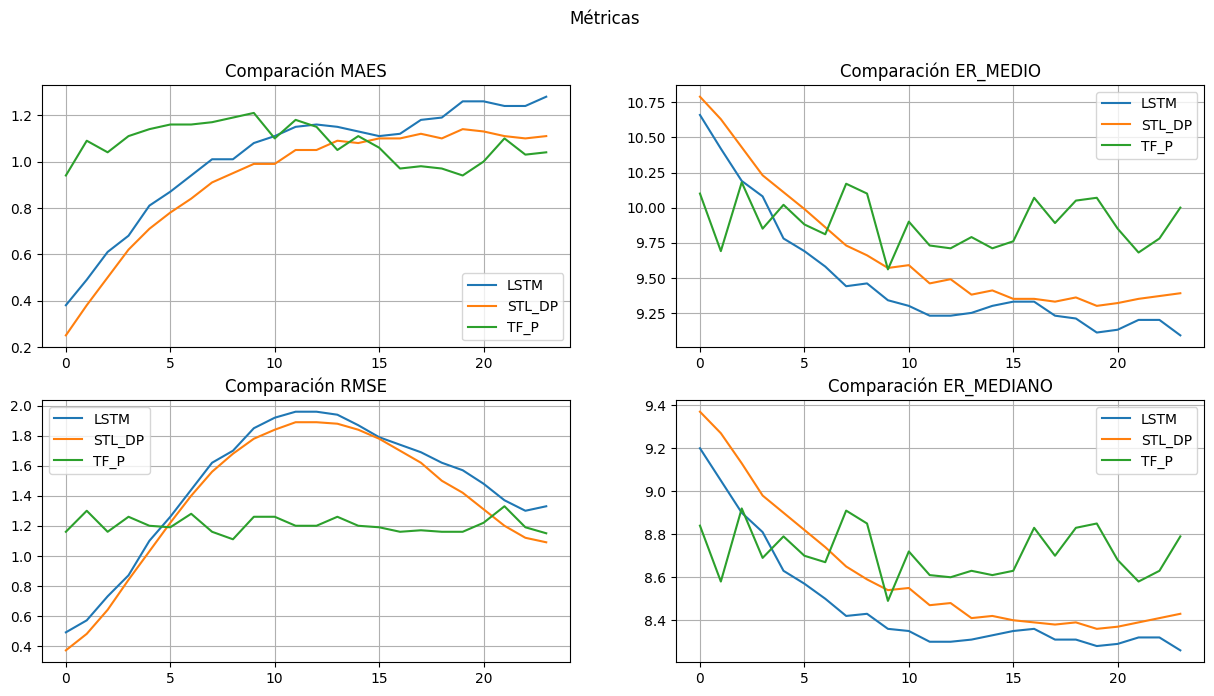

In [83]:
fig, ax = plt.subplots(2, 2,figsize = (15,7.5))
fig.suptitle("Métricas")



ax[0,0].set_title("Comparación MAES")
ax[0,0].plot(Metricas['MAES_LSTM'],label = "LSTM")
ax[0,0].plot(Metricas['MAES_STL_DP'],label = "STL_DP")
ax[0,0].plot(Metricas['MAES_TF_P'],label = "TF_P")
ax[0,0].legend()
ax[0,0].grid()


ax[0,1].set_title("Comparación ER_MEDIO")
ax[0,1].plot(Metricas['ER_MEDIO_LSTM'],label = "LSTM")
ax[0,1].plot(Metricas['ER_MEDIO_STL_DP'],label = "STL_DP")
ax[0,1].plot(Metricas['ER_MEDIO_TF_P'],label = "TF_P")
ax[0,1].legend()
ax[0,1].grid()


ax[1,0].set_title("Comparación RMSE")
ax[1,0].plot(Metricas['RMSE_LSTM'],label = "LSTM")
ax[1,0].plot(Metricas['RMSE_STL_DP'],label = "STL_DP")
ax[1,0].plot(Metricas['RMSE_TF_P'],label = "TF_P")
ax[1,0].legend()
ax[1,0].grid()



ax[1,1].set_title("Comparación ER_MEDIANO")
ax[1,1].plot(Metricas['ER_Medianos_LSTM'],label = "LSTM")
ax[1,1].plot(Metricas['ER_Medianos_STL_DP'],label = "STL_DP")
ax[1,1].plot(Metricas['ER_Medianos_TF_P'],label = "TF_P")
ax[1,1].legend()
ax[1,1].grid()

In [ ]:
# Grafica LSTM, STL,TFP y Real

num = 200


plt.plot(fecha_y_test_STL_DP[num],y_hat_STL_DP[num],label = "Predicción STL_DP")
plt.plot(fecha_y_testLSTM[num],y_hatLSTM[num],label = "Predicción Sin Ruido")

plt.plot(fecha_y_testLSTM[num],y_testLSTM[num],label = "Datos Reales")

plt.xticks(rotation = 45)
plt.legend()
plt.grid()